In [1]:
import posixpath
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
from shapely.geometry import Polygon
from shapely import plotting
import matplotlib.pyplot as plt
import datetime
import scipy
import distances

## Load datasets and count glaciers

In [2]:
data_root = "D:/OneDrive/Documents/Cours/4A/SFE/data/"

kh_fronts = gpd.read_file(posixpath.join(data_root, "KH-5_ARGON_fronts/KH-5_ARGON_fronts.shp")).to_crs(epsg=25833)
kh_fronts.head()

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
0,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00777,RGI2000-v7.0-G-07-01225,3,E,"LINESTRING (447461.671 8832029.666, 447497.042..."
1,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00775,RGI2000-v7.0-G-07-01229,4,SE,"LINESTRING (446131.469 8835920.477, 446232.529..."
2,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00709,RGI2000-v7.0-G-07-00011,25,W,"LINESTRING (416080.008 8819152.093, 416146.96 ..."
3,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00664,RGI2000-v7.0-G-07-00015,26,W,"LINESTRING (415736.404 8813938.659, 415733.877..."
4,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00663,RGI2000-v7.0-G-07-00016,27,W,"LINESTRING (417320.52 8806789.925, 417358.417 ..."


In [3]:
landsat_fronts = gpd.read_file(posixpath.join(data_root, "Landsat_MSS_fronts/Landsat_MSS_fronts.shp")).to_crs(epsg=25833)
landsat_fronts.head()

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
0,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00791,RGI2000-v7.0-G-07-01223,2,NE,"LINESTRING (446917.357 8830600.499, 446900.231..."
1,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00777,RGI2000-v7.0-G-07-01225,3,E,"LINESTRING (447150.28 8832426.203, 447136.579 ..."
2,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00775,RGI2000-v7.0-G-07-01229,4,SE,"LINESTRING (446105.553 8836403.019, 446122.679..."
3,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00794,RGI2000-v7.0-G-07-01268,5,NE,"LINESTRING (445687.662 8843966.161, 445629.431..."
4,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00790,RGI2000-v7.0-G-07-01266,6,NE,"LINESTRING (442212.658 8844269.303, 442116.749..."


In [4]:
npi_fronts = gpd.read_file(posixpath.join(data_root, "NPI_fronts/NPI_fronts.shp")).to_crs(epsg=25833)
npi_fronts.head()

,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
0,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00006,RGI2000-v7.0-G-07-00787,77,NW,"LINESTRING (532543.309 8544051.053, 532636.725..."
1,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00025,RGI2000-v7.0-G-07-01384,161,S,"LINESTRING (688874.291 8815732.222, 688441.142..."
2,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00035,RGI2000-v7.0-G-07-01365,176,E,"LINESTRING (626236.343 8902937.128, 626351.396..."
3,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00036,RGI2000-v7.0-G-07-01363,177,E,"LINESTRING (610107.299 8911853.037, 610139.55 ..."
4,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.01449,RGI2000-v7.0-G-07-01343,144,NW,"LINESTRING (581931.237 8893586.913, 581984.338..."


In [5]:
all_fronts = pd.concat([npi_fronts, kh_fronts, landsat_fronts], ignore_index=True)
all_fronts.head()

,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry,image
0,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00006,RGI2000-v7.0-G-07-00787,77,NW,"LINESTRING (532543.309 8544051.053, 532636.725...",NaN
1,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00025,RGI2000-v7.0-G-07-01384,161,S,"LINESTRING (688874.291 8815732.222, 688441.142...",NaN
2,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00035,RGI2000-v7.0-G-07-01365,176,E,"LINESTRING (626236.343 8902937.128, 626351.396...",NaN
3,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.00036,RGI2000-v7.0-G-07-01363,177,E,"LINESTRING (610107.299 8911853.037, 610139.55 ...",NaN
4,NPI 1936-1938 aerial survey,1936-01-01,RGI60-07.01449,RGI2000-v7.0-G-07-01343,144,NW,"LINESTRING (581931.237 8893586.913, 581984.338...",NaN


## Polygon method

### KH

Timestamp: 1962-05-16 00:00:00, Mean distance: -45.78 m, Standard deviation: 538.04 m
Timestamp: 1963-08-29 00:00:00, Mean distance: -28.53 m, Standard deviation: 224.52 m
Skipped 40 (2 direction and 38 length) comparisons out of 516.


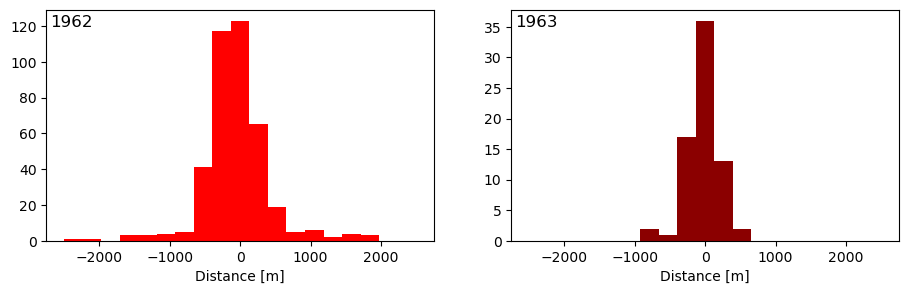

In [ ]:
dists = []
skip_count_len = 0
skip_count_dir = 0
total_count = 0
timestamps = [datetime.datetime(1962, 5, 16), datetime.datetime(1963, 8, 29)]
for timestamp in timestamps:
    dists_timestamp = []
    front_ids = kh_fronts.loc[kh_fronts.timestamp == timestamp].front_id.unique()
    for i_front_id, front_id in enumerate(front_ids):
        fronts = kh_fronts.loc[kh_fronts.front_id == front_id].loc[kh_fronts.timestamp == timestamp]
        for k in range(len(fronts.geometry) - 1):
            for l in range(k + 1, len(fronts.geometry)):
                front1 = fronts.geometry.iloc[k]
                front2 = fronts.geometry.iloc[l]
                dir_1 = fronts.front_dir.iloc[k]
                dir_2 = fronts.front_dir.iloc[l]
                dist, e = distances.distance(front1, front2, dir_1, dir_2)
                if dist == np.nan:
                    print(f"Warning: NaN distance for front_id {front_id}, timestamp {timestamp}, indices {k}, {l}")
                if dist is not None:
                    dists_timestamp.append(dist)
                elif e == 1:
                    skip_count_len += 1
                elif e == 2:
                    skip_count_dir += 1
                total_count += 1
    dists.append(dists_timestamp)
        
dists_npy = [np.array(dists_timestamp) for dists_timestamp in dists]
sigma_kh = [dists_npy_timestamp.std() for dists_npy_timestamp in dists_npy]
mean = [dists_npy_timestamp.mean() for dists_npy_timestamp in dists_npy]

for i in range(len(timestamps)):
    print(f"Timestamp: {timestamps[i]}, Mean distance: {mean[i]:.2f} m, Standard deviation: {sigma_kh[i]:.2f} m")
print(f"Skipped {skip_count_len + skip_count_dir} ({skip_count_dir} direction and {skip_count_len} length) comparisons out of {total_count}.")

fig, axs = plt.subplots(ncols=len(timestamps), figsize=(11, 3))
axs[0].hist(dists[0], bins=np.linspace(-2500, 2500, 20), color="red")
axs[0].set_title(timestamps[0].strftime("%Y"), x=0.01, y=0.89, loc="left")
# axs[0].set_xlabel("Distance [m]")
axs[1].hist(dists[1], bins=np.linspace(-2500, 2500, 20), color="darkred")
axs[1].set_title(timestamps[1].strftime("%Y"), x=0.01, y=0.89, loc="left")
# axs[1].set_xlabel("Distance [m]")
fig.savefig("images/KH-5_ARGON_fonts_accuracy.png", bbox_inches="tight")

### Landsat

Year: 1976, Mean distance: -9.79 m, Standard deviation: 80.61 m
Year: 1978, Mean distance: 16.64 m, Standard deviation: 117.93 m
Skipped 59 (0 direction and 59 length) comparisons out of 337.


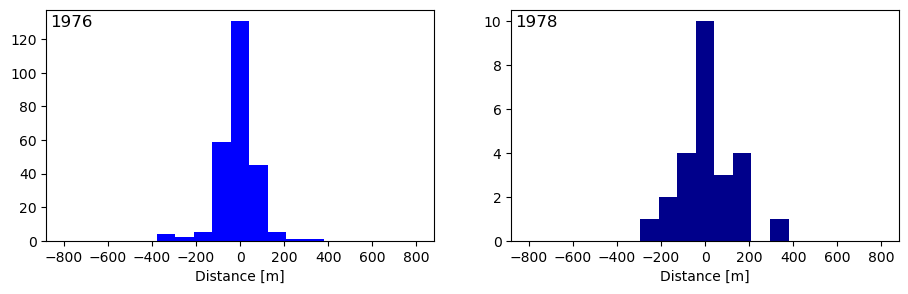

In [34]:
def get_year(timestamp):
    return timestamp.year

dists = []
skip_count_len = 0
skip_count_dir = 0
total_count = 0
years = [1976, 1978]
for year in years:
    dists_year = []
    front_ids = landsat_fronts.loc[landsat_fronts.timestamp.apply(get_year) == year].front_id.unique()
    for front_id in front_ids:
        fronts = landsat_fronts.loc[landsat_fronts.front_id == front_id].loc[landsat_fronts.timestamp.apply(get_year) == year]
        for k in range(len(fronts.geometry) - 1):
            for l in range(k + 1, len(fronts.geometry)):
                front1 = fronts.geometry.iloc[k]
                front2 = fronts.geometry.iloc[l]
                dir_1 = fronts.front_dir.iloc[k]
                dir_2 = fronts.front_dir.iloc[l]
                dist, e = distances.distance(front1, front2, dir_1, dir_2)
                if dist is not None:
                    dists_year.append(dist)
                elif e == 1:
                    skip_count_len += 1
                elif e == 2:
                    skip_count_dir += 1
                total_count += 1
    dists.append(dists_year)
        
dists_npy = [np.array(dists_year) for dists_year in dists]
sigma_landsat = [dists_npy_year.std() for dists_npy_year in dists_npy]
mean = [dists_npy_year.mean() for dists_npy_year in dists_npy]

for i in range(len(years)):
    print(f"Year: {years[i]}, Mean distance: {mean[i]:.2f} m, Standard deviation: {sigma_landsat[i]:.2f} m")
print(f"Skipped {skip_count_len + skip_count_dir} ({skip_count_dir} direction and {skip_count_len} length) comparisons out of {total_count}.")

fig, axs = plt.subplots(ncols=len(years), figsize=(11, 3))
axs[0].hist(dists[0], bins=np.linspace(-800, 800, 20), color="blue")
axs[0].set_title(years[0], x=0.01, y=0.89, loc="left")
axs[0].set_xlabel("Distance [m]")
axs[1].hist(dists[1], bins=np.linspace(-800, 800, 20), color="darkblue")
axs[1].set_title(years[1], x=0.01, y=0.89, loc="left")
axs[1].set_xlabel("Distance [m]")
fig.savefig("images/Landsat_MSS_fonts_accuracy.png", bbox_inches="tight")

### Recompile uncertainties

In [35]:
years = np.array([1962, 1963, 1976, 1978])
sigmas_prime = np.floor(np.concatenate([sigma_kh, sigma_landsat]))
sigmas = np.floor(sigmas_prime / np.sqrt(2))
print(sigmas_prime, sigmas)

[538. 224.  80. 117.] [380. 158.  56.  82.]


In [36]:
uncertainties = pd.DataFrame(
    [],
    columns=["year_1", "year_2", "sigma_dist", "2_sigma_dist", "3_sigma_dist"]
)

for i in range(len(years) - 1):
    for j in range(i, len(years)):
        uncertainties.loc[len(uncertainties)] = [
            years[i],
            years[j],
            np.sqrt(sigmas[i]**2 + sigmas[j]**2),
            2 * np.sqrt(sigmas[i]**2 + sigmas[j]**2),
            3 * np.sqrt(sigmas[i]**2 + sigmas[j]**2)
        ]
    
uncertainties = uncertainties[["year_1", "year_2", "sigma_dist", "2_sigma_dist", "3_sigma_dist"]]
uncertainties

,year_1,year_2,sigma_dist,2_sigma_dist,3_sigma_dist
0,1962.0,1962.0,537.401154,1074.802307,1612.203461
1,1962.0,1963.0,411.538577,823.077153,1234.615730
2,1962.0,1976.0,384.104153,768.208305,1152.312458
3,1962.0,1978.0,388.746704,777.493408,1166.240112
4,1963.0,1963.0,223.445743,446.891486,670.337229
5,1963.0,1976.0,167.630546,335.261092,502.891638
6,1963.0,1978.0,178.011236,356.022471,534.033707
7,1976.0,1976.0,79.195959,158.391919,237.587878
8,1976.0,1978.0,99.297533,198.595065,297.892598


In [37]:
uncertainties.to_csv("./uncertainties_manual.csv", index=False)

## Box method

In [6]:
boxes = gpd.read_file(posixpath.join(data_root, "boxes/boxes.shp")).to_crs(epsg=25833)
boxes.head()

,front_id,front_dir,RGI60ID,RGI70ID,geometry
0,1,NE,RGI60-07.01494,RGI2000-v7.0-G-07-00054,"POLYGON ((448958.093 8831407.133, 451132.965 8..."
1,2,NE,RGI60-07.00791,RGI2000-v7.0-G-07-01223,"POLYGON ((448556.464 8831393.624, 447609.196 8..."
2,3,E,RGI60-07.00777,RGI2000-v7.0-G-07-01225,"POLYGON ((446223.949 8833013.329, 449012.234 8..."
3,4,SE,RGI60-07.00775,RGI2000-v7.0-G-07-01229,"POLYGON ((445849.929 8838239.577, 448611.174 8..."
4,5,NE,RGI60-07.00794,RGI2000-v7.0-G-07-01268,"POLYGON ((444478.132 8842149.605, 443352.455 8..."


### KH

<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\s'
C:\Users\loris\AppData\Local\Temp\ipykernel_21008\3396312927.py:41: SyntaxWarning: invalid escape sequence '\s'
  axs[0].text(0.01, 0.82, f"$\sigma^\prime = {sigma_kh[0]:.0f}$ m", color='black', transform=axs[0].transAxes, fontsize=12, verticalalignment='bottom')
C:\Users\loris\AppData\Local\Temp\ipykernel_21008\3396312927.py:42: SyntaxWarning: invalid escape sequence '\s'
  axs[0].text(0.01, 0.82, f"$\sigma = {sigma_kh[0]/np.sqrt(2):.0f}$ m", color='black', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')
C:\Users\loris\AppData\Local\Temp\ipykernel_21008\3396312927.py

Timestamp: 1962-05-16 00:00:00, Mean distance: -75.90 m, Standard deviation: 707.91 m
Timestamp: 1963-08-29 00:00:00, Mean distance: -21.10 m, Standard deviation: 304.22 m
Skipped 88 comparisons out of 516.


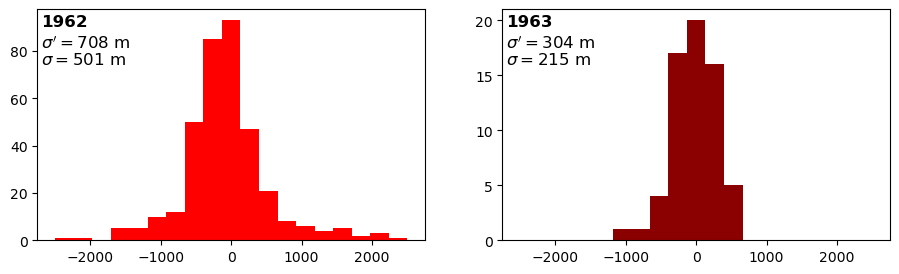

In [7]:
dists = []
skip_count = 0
total_count = 0
timestamps = [datetime.datetime(1962, 5, 16), datetime.datetime(1963, 8, 29)]
for timestamp in timestamps:
    dists_timestamp = []
    front_ids = kh_fronts.loc[kh_fronts.timestamp == timestamp].front_id.unique()
    for i_front_id, front_id in enumerate(front_ids):
        fronts = kh_fronts.loc[kh_fronts.front_id == front_id].loc[kh_fronts.timestamp == timestamp]
        for k in range(len(fronts.geometry) - 1):
            for l in range(k + 1, len(fronts.geometry)):
                front1 = fronts.geometry.iloc[k]
                front2 = fronts.geometry.iloc[l]
                dir_1 = fronts.front_dir.iloc[k]
                dir_2 = fronts.front_dir.iloc[l]
                if not boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].empty:
                    box = boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].geometry.values[0]
                    dist, e = distances.box_distance(front1, front2, box, dir_1, dir_2)
                    # if dist == np.nan:
                    #     print(f"Warning: NaN distance for front_id {front_id}, timestamp {timestamp}, indices {k}, {l}")
                    if dist is not None:
                        dists_timestamp.append(dist)
                    elif e == 1:
                        skip_count += 1
                else:
                    skip_count += 1
                total_count += 1
    dists.append(dists_timestamp)
        
dists_npy = [np.array(dists_timestamp) for dists_timestamp in dists]
sigma_kh = [dists_npy_timestamp.std() for dists_npy_timestamp in dists_npy]
mean = [dists_npy_timestamp.mean() for dists_npy_timestamp in dists_npy]

for i in range(len(timestamps)):
    print(f"Timestamp: {timestamps[i]}, Mean distance: {mean[i]:.2f} m, Standard deviation: {sigma_kh[i]:.2f} m")
print(f"Skipped {skip_count} comparisons out of {total_count}.")

fig, axs = plt.subplots(ncols=len(timestamps), figsize=(11, 3))
axs[0].hist(dists[0], bins=np.linspace(-2500, 2500, 20), color="red")
axs[0].set_title(timestamps[0].strftime("%Y"), x=0.01, y=0.89, loc="left", fontweight="semibold")
axs[0].text(0.01, 0.82, f"$\sigma^\prime = {sigma_kh[0]:.0f}$ m", color='black', transform=axs[0].transAxes, fontsize=12, verticalalignment='bottom')
axs[0].text(0.01, 0.82, f"$\sigma = {sigma_kh[0]/np.sqrt(2):.0f}$ m", color='black', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')
# axs[0].set_xlabel("Distance [m]")
axs[1].hist(dists[1], bins=np.linspace(-2500, 2500, 20), color="darkred")
axs[1].set_title(timestamps[1].strftime("%Y"), x=0.01, y=0.89, loc="left", fontweight="semibold")
axs[1].text(0.01, 0.82, f"$\sigma^\prime = {sigma_kh[1]:.0f}$ m", color='black', transform=axs[1].transAxes, fontsize=12, verticalalignment='bottom')
axs[1].text(0.01, 0.82, f"$\sigma = {sigma_kh[1]/np.sqrt(2):.0f}$ m", color='black', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')
# axs[0].set_xlabel("Distance [m]")
fig.savefig("images/KH-5_ARGON_fonts_accuracy_box.png", bbox_inches="tight")

### Landsat

<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
C:\Users\loris\AppData\Local\Temp\ipykernel_21008\2453617052.py:42: SyntaxWarning: invalid escape sequence '\s'
  axs[0].text(0.01, 0.82, f"$\sigma^\prime = {sigma_landsat[0]:.0f}$ m", color='black', transform=axs[0].transAxes, fontsize=12, verticalalignment='bottom')
C:\Users\loris\AppData\Local\Temp\ipykernel_21008\2453617052.py:43: SyntaxWarning: invalid escape sequence '\s'
  axs[0].text(0.01, 0.82, f"$\sigma = {sigma_landsat[0]/np.sqrt(2):.0f}$ m", color='black', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')
C:\Users\loris\AppData\Local\Temp\ipykernel_21008\245

Year: 1976, Mean distance: -15.85 m, Standard deviation: 135.86 m
Year: 1978, Mean distance: -4.80 m, Standard deviation: 139.03 m
Skipped 108 comparisons out of 337.


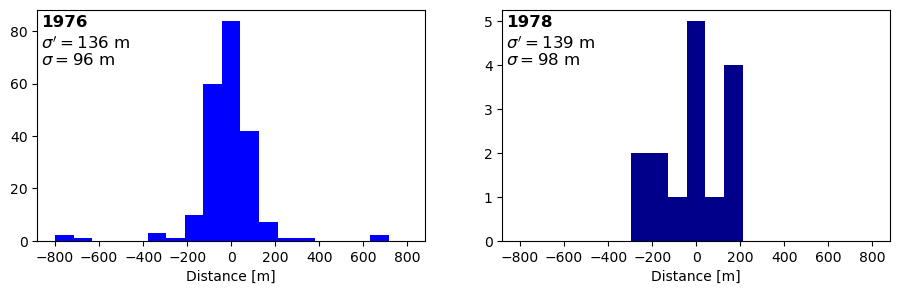

In [8]:
def get_year(timestamp):
    return timestamp.year

dists = []
skip_count = 0
total_count = 0
years = [1976, 1978]
for year in years:
    dists_year = []
    front_ids = landsat_fronts.loc[landsat_fronts.timestamp.apply(get_year) == year].front_id.unique()
    for front_id in front_ids:
        fronts = landsat_fronts.loc[landsat_fronts.front_id == front_id].loc[landsat_fronts.timestamp.apply(get_year) == year]
        for k in range(len(fronts.geometry) - 1):
            for l in range(k + 1, len(fronts.geometry)):
                front1 = fronts.geometry.iloc[k]
                front2 = fronts.geometry.iloc[l]
                dir_1 = fronts.front_dir.iloc[k]
                dir_2 = fronts.front_dir.iloc[l]
                if not boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].empty:
                    box = boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].geometry.values[0]
                    dist, e = distances.box_distance(front1, front2, box, dir_1, dir_2)
                    if dist is not None:
                        dists_year.append(dist)
                    elif e == 1:
                        skip_count += 1
                else:
                    skip_count += 1
                total_count += 1
    dists.append(dists_year)
        
dists_npy = [np.array(dists_year) for dists_year in dists]
sigma_landsat = [dists_npy_year.std() for dists_npy_year in dists_npy]
mean = [dists_npy_year.mean() for dists_npy_year in dists_npy]

for i in range(len(years)):
    print(f"Year: {years[i]}, Mean distance: {mean[i]:.2f} m, Standard deviation: {sigma_landsat[i]:.2f} m")
print(f"Skipped {skip_count} comparisons out of {total_count}.")

fig, axs = plt.subplots(ncols=len(years), figsize=(11, 3))
axs[0].hist(dists[0], bins=np.linspace(-800, 800, 20), color="blue")
axs[0].set_title(years[0], x=0.01, y=0.89, loc="left", fontweight="semibold")
axs[0].text(0.01, 0.82, f"$\sigma^\prime = {sigma_landsat[0]:.0f}$ m", color='black', transform=axs[0].transAxes, fontsize=12, verticalalignment='bottom')
axs[0].text(0.01, 0.82, f"$\sigma = {sigma_landsat[0]/np.sqrt(2):.0f}$ m", color='black', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')
axs[0].set_xlabel("Distance [m]")
axs[1].hist(dists[1], bins=np.linspace(-800, 800, 20), color="darkblue")
axs[1].set_title(years[1], x=0.01, y=0.89, loc="left", fontweight="semibold")
axs[1].text(0.01, 0.82, f"$\sigma^\prime = {sigma_landsat[1]:.0f}$ m", color='black', transform=axs[1].transAxes, fontsize=12, verticalalignment='bottom')
axs[1].text(0.01, 0.82, f"$\sigma = {sigma_landsat[1]/np.sqrt(2):.0f}$ m", color='black', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')
axs[1].set_xlabel("Distance [m]")
fig.savefig("images/Landsat_MSS_fonts_accuracy_box.png", bbox_inches="tight")

### Recompile uncertainties

In [9]:
years = np.array([1936, 1962, 1963, 1976, 1978])
sigmas_prime_0 = np.concatenate([sigma_kh, sigma_landsat])

# adding 30 m uncertainty for NPI aerial photos
sigmas_prime = np.zeros(len(years))
sigmas_prime[0] = 30
sigmas_prime[1:] = sigmas_prime_0
sigmas = np.floor(sigmas_prime / np.sqrt(2))
sigmas_prime = np.floor(sigmas_prime)

print(sigmas_prime, sigmas)

[ 30. 707. 304. 135. 139.] [ 21. 500. 215.  96.  98.]


In [10]:
uncertainties_box = pd.DataFrame(
    [],
    columns=["year_1", "year_2", "sigma_dist", "2_sigma_dist", "3_sigma_dist"]
)

for i in range(len(years) - 1):
    for j in range(i, len(years)):
        uncertainties_box.loc[len(uncertainties_box)] = [
            years[i],
            years[j],
            np.sqrt(sigmas[i]**2 + sigmas[j]**2),
            2 * np.sqrt(sigmas[i]**2 + sigmas[j]**2),
            3 * np.sqrt(sigmas[i]**2 + sigmas[j]**2)
        ]
        

uncertainties_box = uncertainties_box[["year_1", "year_2", "sigma_dist", "2_sigma_dist", "3_sigma_dist"]]
uncertainties_box

,year_1,year_2,sigma_dist,2_sigma_dist,3_sigma_dist
0,1936.0,1936.0,29.698485,59.396970,89.095454
1,1936.0,1962.0,500.440806,1000.881611,1501.322417
2,1936.0,1963.0,216.023147,432.046294,648.069441
3,1936.0,1976.0,98.270036,196.540072,294.810108
4,1936.0,1978.0,100.224747,200.449495,300.674242
5,1962.0,1962.0,707.106781,1414.213562,2121.320344
6,1962.0,1963.0,544.265560,1088.531120,1632.796681
7,1962.0,1976.0,509.132596,1018.265191,1527.397787
8,1962.0,1978.0,509.513493,1019.026987,1528.540480
9,1963.0,1963.0,304.055916,608.111832,912.167748


In [11]:
uncertainties_box.to_csv("./uncertainties_box.csv", index=False)

In [12]:
uncertainties_box_single = pd.DataFrame(
    np.array([years, sigmas]).T,
    columns = ["year", "sigma"]
)
uncertainties_box_single.to_csv("./uncertainties_box_single.csv", index=False)

## Curvilinear centerline method

In [13]:
centerlines = gpd.read_file(posixpath.join(data_root, "centerlines/centerlines.shp")).to_crs(epsg=25833)
centerlines.head()

,front_id,front_dir,RGI60ID,RGI70ID,geometry
0,73,S,RGI60-07.00324,RGI2000-v7.0-G-07-01545,"LINESTRING (534321.434 8546768.732, 534362.547..."
1,68,SE,RGI60-07.00244,RGI2000-v7.0-G-07-01541,"LINESTRING (521713.665 8552295.499, 521056.825..."
2,61,NW,RGI60-07.00235,RGI2000-v7.0-G-07-00899,"LINESTRING (522358.058 8605537.509, 522635.212..."
3,96,SE,RGI60-07.00422,RGI2000-v7.0-G-07-00916,"LINESTRING (560900.741 8615217.504, 561141.212..."
4,1,NE,RGI60-07.01494,RGI2000-v7.0-G-07-00054,"LINESTRING (449615.704 8824196.706, 449565.438..."


<>:39: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
C:\Users\loris\AppData\Local\Temp\ipykernel_21008\1004999525.py:39: SyntaxWarning: invalid escape sequence '\s'
  axs[0].text(0.01, 0.82, f"$\sigma^\prime = {sigma_kh[0]:.0f}$ m", color='black', transform=axs[0].transAxes, fontsize=12, verticalalignment='bottom')
C:\Users\loris\AppData\Local\Temp\ipykernel_21008\1004999525.py:40: SyntaxWarning: invalid escape sequence '\s'
  axs[0].text(0.01, 0.82, f"$\sigma = {sigma_kh[0]/np.sqrt(2):.0f}$ m", color='black', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')
C:\Users\loris\AppData\Local\Temp\ipykernel_21008\1004999525.py

Timestamp: 1962-05-16 00:00:00, Mean distance: -7.65 m, Standard deviation: 509.56 m
Timestamp: 1963-08-29 00:00:00, Mean distance: -24.73 m, Standard deviation: 256.87 m
Skipped 19 comparisons out of 516.


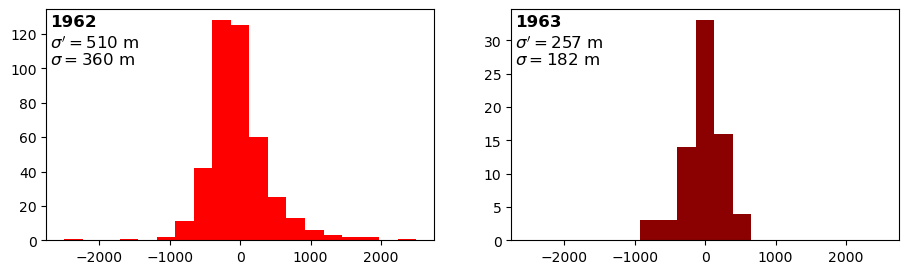

In [14]:
dists = []
skip_count = 0
total_count = 0
timestamps = [datetime.datetime(1962, 5, 16), datetime.datetime(1963, 8, 29)]
for timestamp in timestamps:
    dists_timestamp = []
    front_ids = kh_fronts.loc[kh_fronts.timestamp == timestamp].front_id.unique()
    for i_front_id, front_id in enumerate(front_ids):
        fronts = kh_fronts.loc[kh_fronts.front_id == front_id].loc[kh_fronts.timestamp == timestamp]
        for k in range(len(fronts.geometry) - 1):
            for l in range(k + 1, len(fronts.geometry)):
                front1 = fronts.geometry.iloc[k]
                front2 = fronts.geometry.iloc[l]
                dir_1 = fronts.front_dir.iloc[k]
                dir_2 = fronts.front_dir.iloc[l]
                if not centerlines.loc[centerlines.front_id == fronts.front_id.iloc[k]].empty:
                    cl = centerlines.loc[centerlines.front_id == fronts.front_id.iloc[k]].geometry.values[0]
                    dist, e = distances.curvilinear_distance(front1, front2, cl, dir_1, dir_2)
                    if dist is not None:
                        dists_timestamp.append(dist)
                    elif e == 1:
                        skip_count += 1
                else:
                    skip_count += 1
                total_count += 1
    dists.append(dists_timestamp)
        
dists_npy = [np.array(dists_timestamp) for dists_timestamp in dists]
sigma_kh = [dists_npy_timestamp.std() for dists_npy_timestamp in dists_npy]
mean = [dists_npy_timestamp.mean() for dists_npy_timestamp in dists_npy]

for i in range(len(timestamps)):
    print(f"Timestamp: {timestamps[i]}, Mean distance: {mean[i]:.2f} m, Standard deviation: {sigma_kh[i]:.2f} m")
print(f"Skipped {skip_count} comparisons out of {total_count}.")

fig, axs = plt.subplots(ncols=len(timestamps), figsize=(11, 3))
axs[0].hist(dists[0], bins=np.linspace(-2500, 2500, 20), color="red")
axs[0].set_title(timestamps[0].strftime("%Y"), x=0.01, y=0.89, loc="left", fontweight="semibold")
axs[0].text(0.01, 0.82, f"$\sigma^\prime = {sigma_kh[0]:.0f}$ m", color='black', transform=axs[0].transAxes, fontsize=12, verticalalignment='bottom')
axs[0].text(0.01, 0.82, f"$\sigma = {sigma_kh[0]/np.sqrt(2):.0f}$ m", color='black', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')

# axs[0].set_xlabel("Distance [m]")
axs[1].hist(dists[1], bins=np.linspace(-2500, 2500, 20), color="darkred")
axs[1].set_title(timestamps[1].strftime("%Y"), x=0.01, y=0.89, loc="left", fontweight="semibold")
axs[1].text(0.01, 0.82, f"$\sigma^\prime = {sigma_kh[1]:.0f}$ m", color='black', transform=axs[1].transAxes, fontsize=12, verticalalignment='bottom')
axs[1].text(0.01, 0.82, f"$\sigma = {sigma_kh[1]/np.sqrt(2):.0f}$ m", color='black', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')
# axs[0].set_xlabel("Distance [m]")
fig.savefig("images/KH-5_ARGON_fonts_accuracy_cl.png", bbox_inches="tight")

<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
C:\Users\loris\AppData\Local\Temp\ipykernel_21008\286968115.py:42: SyntaxWarning: invalid escape sequence '\s'
  axs[0].text(0.01, 0.82, f"$\sigma^\prime = {sigma_landsat[0]:.0f}$ m", color='black', transform=axs[0].transAxes, fontsize=12, verticalalignment='bottom')
C:\Users\loris\AppData\Local\Temp\ipykernel_21008\286968115.py:43: SyntaxWarning: invalid escape sequence '\s'
  axs[0].text(0.01, 0.82, f"$\sigma = {sigma_landsat[0]/np.sqrt(2):.0f}$ m", color='black', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')
C:\Users\loris\AppData\Local\Temp\ipykernel_21008\28696

Year: 1976, Mean distance: -26.56 m, Standard deviation: 189.10 m
Year: 1978, Mean distance: -17.04 m, Standard deviation: 99.98 m
Skipped 38 comparisons out of 337.


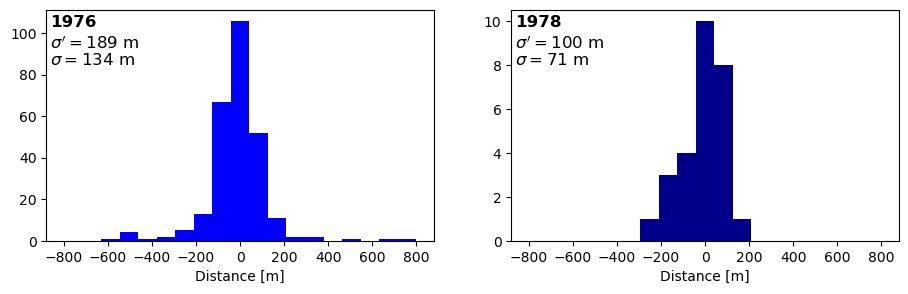

In [15]:
def get_year(timestamp):
    return timestamp.year

dists = []
skip_count = 0
total_count = 0
years = [1976, 1978]
for year in years:
    dists_year = []
    front_ids = landsat_fronts.loc[landsat_fronts.timestamp.apply(get_year) == year].front_id.unique()
    for front_id in front_ids:
        fronts = landsat_fronts.loc[landsat_fronts.front_id == front_id].loc[landsat_fronts.timestamp.apply(get_year) == year]
        for k in range(len(fronts.geometry) - 1):
            for l in range(k + 1, len(fronts.geometry)):
                front1 = fronts.geometry.iloc[k]
                front2 = fronts.geometry.iloc[l]
                dir_1 = fronts.front_dir.iloc[k]
                dir_2 = fronts.front_dir.iloc[l]
                if not centerlines.loc[centerlines.front_id == fronts.front_id.iloc[k]].empty:
                    cl = centerlines.loc[centerlines.front_id == fronts.front_id.iloc[k]].geometry.values[0]
                    dist, e = distances.curvilinear_distance(front1, front2, cl, dir_1, dir_2)
                    if dist is not None:
                        dists_year.append(dist)
                    elif e == 1:
                        skip_count += 1
                else:
                    skip_count += 1
                total_count += 1
    dists.append(dists_year)
        
dists_npy = [np.array(dists_year) for dists_year in dists]
sigma_landsat = [dists_npy_year.std() for dists_npy_year in dists_npy]
mean = [dists_npy_year.mean() for dists_npy_year in dists_npy]

for i in range(len(years)):
    print(f"Year: {years[i]}, Mean distance: {mean[i]:.2f} m, Standard deviation: {sigma_landsat[i]:.2f} m")
print(f"Skipped {skip_count} comparisons out of {total_count}.")

fig, axs = plt.subplots(ncols=len(years), figsize=(11, 3))
axs[0].hist(dists[0], bins=np.linspace(-800, 800, 20), color="blue")
axs[0].set_title(years[0], x=0.01, y=0.89, loc="left", fontweight="semibold")
axs[0].text(0.01, 0.82, f"$\sigma^\prime = {sigma_landsat[0]:.0f}$ m", color='black', transform=axs[0].transAxes, fontsize=12, verticalalignment='bottom')
axs[0].text(0.01, 0.82, f"$\sigma = {sigma_landsat[0]/np.sqrt(2):.0f}$ m", color='black', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')
axs[0].set_xlabel("Distance [m]")
axs[1].hist(dists[1], bins=np.linspace(-800, 800, 20), color="darkblue")
axs[1].set_title(years[1], x=0.01, y=0.89, loc="left", fontweight="semibold")
axs[1].text(0.01, 0.82, f"$\sigma^\prime = {sigma_landsat[1]:.0f}$ m", color='black', transform=axs[1].transAxes, fontsize=12, verticalalignment='bottom')
axs[1].text(0.01, 0.82, f"$\sigma = {sigma_landsat[1]/np.sqrt(2):.0f}$ m", color='black', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')
axs[1].set_xlabel("Distance [m]")
fig.savefig("images/Landsat_MSS_fonts_accuracy_cl.png", bbox_inches="tight")

In [16]:
years = np.array([1936, 1962, 1963, 1976, 1978])
sigmas_prime_0 = np.concatenate([sigma_kh, sigma_landsat])

# adding 30 m uncertainty for NPI aerial photos
sigmas_prime = np.zeros(len(years))
sigmas_prime[0] = 30
sigmas_prime[1:] = sigmas_prime_0
sigmas = np.floor(sigmas_prime / np.sqrt(2))
sigmas_prime = np.floor(sigmas_prime)

print(sigmas_prime, sigmas)

[ 30. 509. 256. 189.  99.] [ 21. 360. 181. 133.  70.]


In [17]:
uncertainties_cl = pd.DataFrame(
    [],
    columns=["year_1", "year_2", "sigma_dist", "2_sigma_dist", "3_sigma_dist"]
)

for i in range(len(years) - 1):
    for j in range(i, len(years)):
        uncertainties_cl.loc[len(uncertainties_cl)] = [
            years[i],
            years[j],
            np.sqrt(sigmas[i]**2 + sigmas[j]**2),
            2 * np.sqrt(sigmas[i]**2 + sigmas[j]**2),
            3 * np.sqrt(sigmas[i]**2 + sigmas[j]**2)
        ]
        

uncertainties_cl = uncertainties_cl[["year_1", "year_2", "sigma_dist", "2_sigma_dist", "3_sigma_dist"]]
uncertainties_cl

,year_1,year_2,sigma_dist,2_sigma_dist,3_sigma_dist
0,1936.0,1936.0,29.698485,59.396970,89.095454
1,1936.0,1962.0,360.611980,721.223960,1081.835940
2,1936.0,1963.0,182.214160,364.428319,546.642479
3,1936.0,1976.0,134.647688,269.295377,403.943065
4,1936.0,1978.0,73.082146,146.164291,219.246437
5,1962.0,1962.0,509.116882,1018.233765,1527.350647
6,1962.0,1963.0,402.940442,805.880884,1208.821327
7,1962.0,1976.0,383.782490,767.564981,1151.347471
8,1962.0,1978.0,366.742416,733.484833,1100.227249
9,1963.0,1963.0,255.972655,511.945310,767.917964


In [18]:
uncertainties_cl.to_csv("./uncertainties_cl.csv", index=False)

In [19]:
uncertainties_cl_single = pd.DataFrame(
    np.array([years, sigmas]).T,
    columns = ["year", "sigma"]
)
uncertainties_cl_single.to_csv("./uncertainties_cl_single.csv", index=False)